## Experiments for the course project

In [4]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from matplotlib import pyplot
from matplotlib.pyplot import figure

In [6]:
x_train = pd.read_parquet('../dataset/labelencode_train.parquet')
x_train, x_test = train_test_split(x_train, train_size=0.8, test_size=0.2, shuffle=True)

In [7]:
cols = list(x_train.columns.values)
cols.remove('encounter_id')
cols.remove('diabetes_mellitus')

x_tr = x_train[cols].values
y_tr = x_train['diabetes_mellitus'].values
x_te = x_test[cols].values
y_te = x_test['diabetes_mellitus'].values

In [11]:
tuned_parameters_dt = [{'splitter':['best', 'random'], 'max_depth': list(range(1,20)),
                        'min_samples_split':list(range(2,20)), 'min_samples_leaf':list(range(1,20)),
                        'max_leaf_nodes': list(range(2,20))}]

scores = {'f1': 'f1_macro', 'roc':'roc_auc_ovr' , 'prec': 'precision'}     

clf = RandomizedSearchCV(DecisionTreeClassifier(), tuned_parameters_dt,
                   scoring=scores, 
                   refit= "f1",
                   cv=4,
                   verbose=1,
                   n_jobs=1,
                   n_iter= 80,)

clf.fit(x_tr, y_tr)
# Validation
pred = clf.best_estimator_.predict_proba(x_te)
pred_bin = clf.best_estimator_.predict(x_te)
roc = roc_auc_score(y_te, pred[:,1])
print("ROC test split = ", roc)
print(classification_report(y_te, pred_bin, digits=4 ))
print(clf.best_params_)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


/Users/grace/.pyenv/versions/3.7.2/envs/law_er/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grace/.pyenv/versions/3.7.2/envs/law_er/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grace/.pyenv/versions/3.7.2/envs/law_er/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grace/.pyenv/ve

/Users/grace/.pyenv/versions/3.7.2/envs/law_er/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grace/.pyenv/versions/3.7.2/envs/law_er/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grace/.pyenv/versions/3.7.2/envs/law_er/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grace/.pyenv/ve

RandomizedSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_iter=80,
                   n_jobs=1,
                   param_distributions=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19],
                                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                            9, 10, 11, 12, 13,
                                                            14, 15, 16, 17, 18,
                                                            19],
                                         'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14, 15,
                                                              16, 17, 18, 19],
                                         'min

ROC test split =  0.7397709378593478
              precision    recall  f1-score   support

           0     0.8125    0.9604    0.8803     16290
           1     0.5889    0.2037    0.3028      4535

    accuracy                         0.7956     20825
   macro avg     0.7007    0.5821    0.5915     20825
weighted avg     0.7638    0.7956    0.7545     20825

{'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_leaf_nodes': 7, 'max_depth': 5}


In [12]:
clf.best_params_

{'splitter': 'random',
 'min_samples_split': 3,
 'min_samples_leaf': 12,
 'max_leaf_nodes': 7,
 'max_depth': 5}

### Model
- decision tree

In [14]:
best_params = {'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 12,
 'max_leaf_nodes': 7, 'max_depth': 5}

In [15]:
def run_experiment(model_param, attrib, attrib_list):
    pos_outcomes = {}
    for att in attrib_list:
        model_param[attrib] = att
        print(model_param)
        model = DecisionTreeClassifier(**model_param)
        model.fit(x_tr, y_tr)
        y_pred = model.predict_proba(x_te)
        pos_outcomes[att] = y_pred[:, 1].copy()
    return pos_outcomes

In [23]:
def draw_plot(outcomes, pos_prefix, title, file_name):
    # plot the roc curve for the model
    fig = figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

    rand_auc = [0 for _ in range(len(y_te))]
    ns_auc = roc_auc_score(y_te, rand_auc)
    print('Random: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_te, rand_auc)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')

    for k, p in outcomes.items():
        # calculate scores    
        xgb_auc = roc_auc_score(y_te, p)
        print('Decision Tree %s: ROC AUC=%.3f' % (k, xgb_auc))
        xgb_fpr, xgb_tpr, _ = roc_curve(y_te, p)
        pyplot.plot(xgb_fpr, xgb_tpr, label=pos_prefix+str(k))

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.title(title)

    pyplot.show()
    fig.savefig(file_name)

### splitter

{'splitter': 'best', 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 11}
Random: ROC AUC=0.500
Decision Tree best: ROC AUC=0.773
Decision Tree random: ROC AUC=0.745


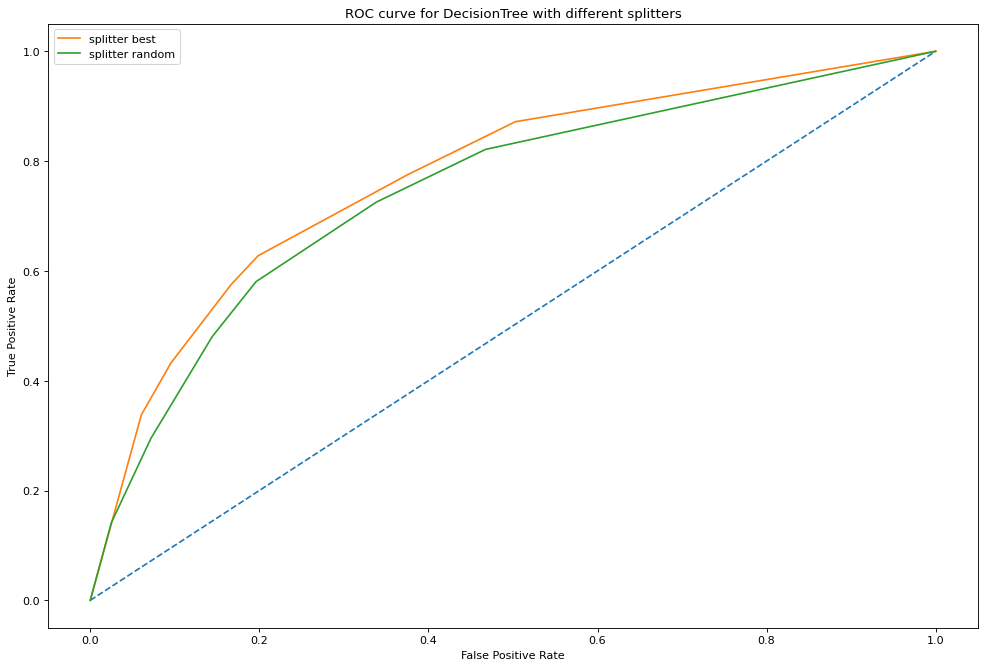

In [24]:
pos_outcomes = run_experiment(best_params, 'splitter', ['best', 'random'])
draw_plot(pos_outcomes, 'splitter ', 'ROC curve for DecisionTree with different splitters', 
          '../imgs/dt_labelencoding_splittervariations.png')

### min_sample_split

{'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 11}
Random: ROC AUC=0.500
Decision Tree 3: ROC AUC=0.768
Decision Tree 5: ROC AUC=0.748
Decision Tree 7: ROC AUC=0.753
Decision Tree 9: ROC AUC=0.772
Decision Tree 11: ROC AUC=0.768


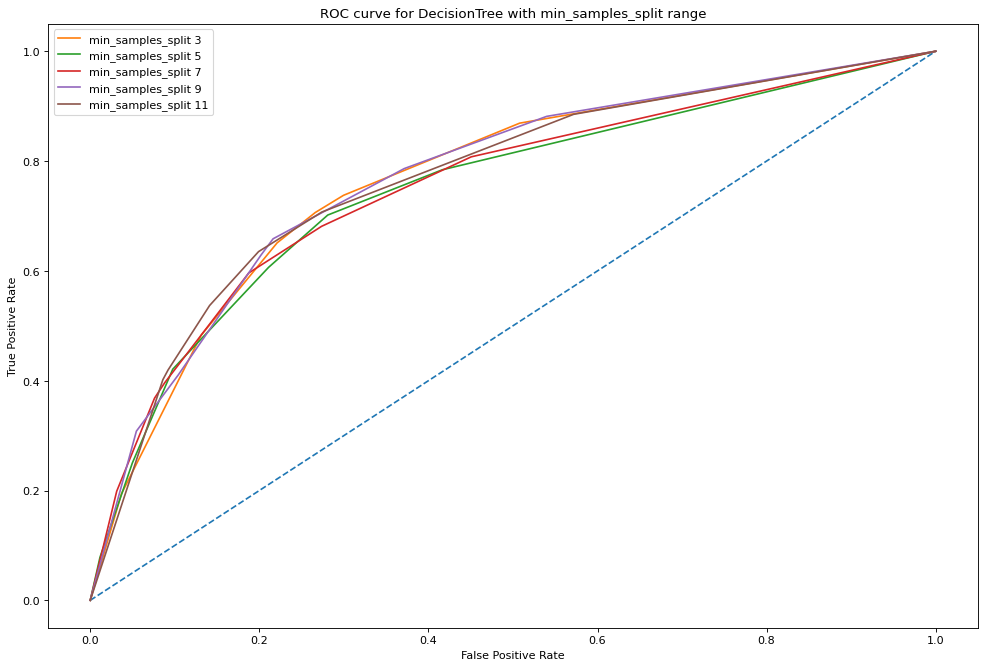

In [25]:
pos_outcomes = run_experiment(best_params, 'min_samples_split', [3, 5, 7, 9, 11])
draw_plot(pos_outcomes, 'min_samples_split ', 'ROC curve for DecisionTree with min_samples_split range', 
          '../imgs/dt_labelencoding_min_samples_splitvariations.png')

### min_samples_leaf

{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_leaf_nodes': 7, 'max_depth': 11}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 11}
Random: ROC AUC=0.500
Decision Tree 4: ROC AUC=0.743
Decision Tree 6: ROC AUC=0.766
Decision Tree 8: ROC AUC=0.729
Decision Tree 10: ROC AUC=0.757
Decision Tree 12: ROC AUC=0.768
Decision Tree 14: ROC AUC=0.739


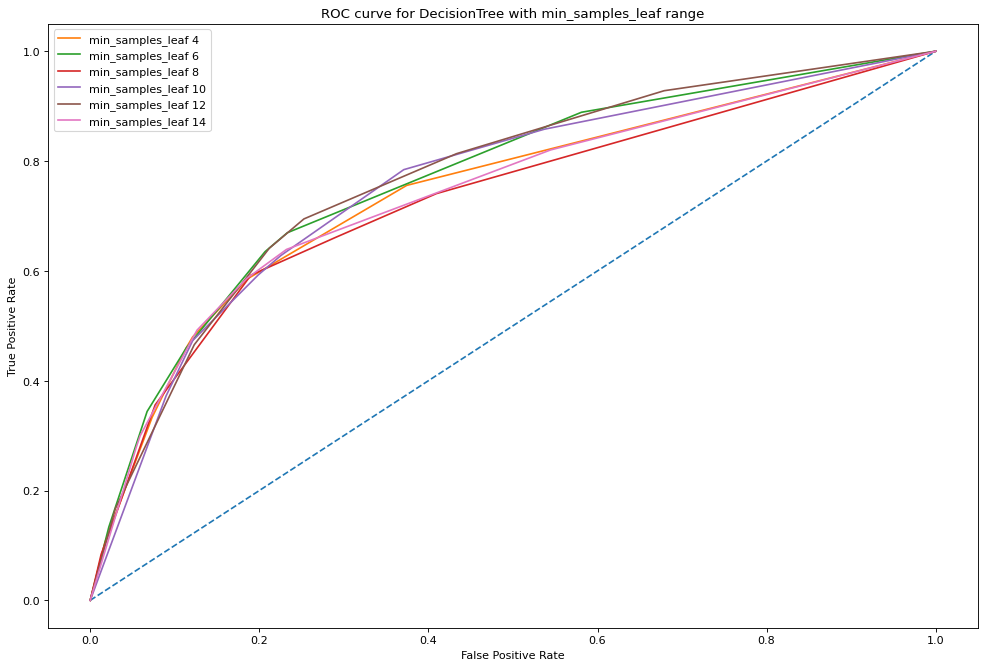

In [26]:
pos_outcomes = run_experiment(best_params, 'min_samples_leaf', [4, 6, 8, 10, 12, 14])
draw_plot(pos_outcomes, 'min_samples_leaf ', 'ROC curve for DecisionTree with min_samples_leaf range', 
          '../imgs/dt_labelencoding_min_samples_leafvariations.png')

{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 3}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 5}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 7}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 9}
{'splitter': 'random', 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 7, 'max_depth': 11}
Random: ROC AUC=0.500
Decision Tree 3: ROC AUC=0.764
Decision Tree 5: ROC AUC=0.754
Decision Tree 7: ROC AUC=0.701
Decision Tree 9: ROC AUC=0.747
Decision Tree 11: ROC AUC=0.763


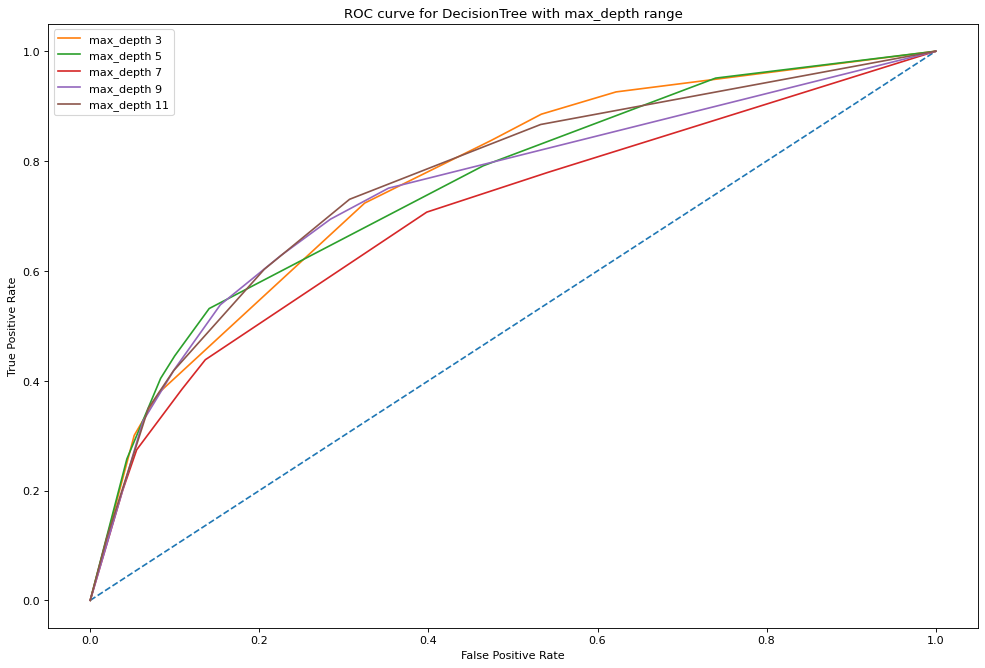

In [27]:
pos_outcomes = run_experiment(best_params, 'max_depth', [3, 5, 7, 9, 11])
draw_plot(pos_outcomes, 'max_depth ', 'ROC curve for DecisionTree with max_depth range', 
          '../imgs/dt_labelencoding_max_depthvariations.png')